## **Import Libraries**

In [ ]:
!pip install transformers
import torch
import os
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AdamW, BertForQuestionAnswering, BertTokenizer, get_linear_schedule_with_warmup
from transformers.data.processors.squad import SquadV2Processor, squad_convert_examples_to_features
import numpy as np
import random
import collections
import re
import string
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
from torch.nn.utils import clip_grad_norm_

## **Set Seed for reproducibility**

In [ ]:
#set the seed value for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## **Load base model and tokenizer**

In [ ]:
# Initiating model loading and tokenizer setup

base_model_identifier ='bert-base-uncased'

# Check the availability of the compute device
if torch.cuda.is_available():
  compute_device = torch.device('cuda')
else:
  compute_device = torch.device('cpu')
# Push model to available device
QA_model = BertForQuestionAnswering.from_pretrained(base_model_identifier).to(compute_device)

# Load the tokenizer
tokenizer_bert = BertTokenizer.from_pretrained(base_model_identifier)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## **Dataset Loading and Preprocessing**

In [ ]:
# Establish a connection to access the files in the drive
drive.mount("/content/drive")

# Load and processing the Squad v2 data
data_processor = SquadV2Processor()
# Load the Training data from drive
training_data = data_processor.get_train_examples("/content/drive/MyDrive/", filename="train-v2.0.json")
# Load the Validation data from the drive
valid_data = data_processor.get_dev_examples("/content/drive/MyDrive/", filename="dev-v2.0.json")

# Function to convert dataset examples to a trainable format
def convert_raw_examples_to_features(dataset, text_tokenizer, sequence_length, stride, query_length, is_training):
    processed_features = squad_convert_examples_to_features(
        examples=dataset,
        tokenizer=text_tokenizer,
        max_seq_length=sequence_length,
        doc_stride=stride,
        max_query_length=query_length,
        is_training=is_training
    )
    # Handle unanswerable questions by making the start and end position to cls_index
    for feature in processed_features:
        if feature.is_impossible:
            feature.start_position = feature.cls_index
            feature.end_position = feature.cls_index
    return processed_features

# Check if processed data is already saved in the drive
path_to_train_data = "/content/drive/MyDrive/train_data_features.pkl"
path_to_valid_data = "/content/drive/MyDrive/validation_data_features.pkl"
if os.path.exists(path_to_train_data) and os.path.exists(path_to_valid_data):
    with open(path_to_train_data, "rb") as f:
        training_data_features = pickle.load(f)
    with open(path_to_valid_data, "rb") as f:
        validation_data_features = pickle.load(f)
else:
    training_data_features = convert_raw_examples_to_features(training_data, tokenizer_bert, 384, 128, 64, True)
    validation_data_features = convert_raw_examples_to_features(valid_data, tokenizer_bert, 384, 128, 64, False)
    # Save the processed features for future use
    with open(path_to_train_data, "wb") as f:
        pickle.dump(training_data_features, f)
    with open(path_to_valid_data, "wb") as f:
        pickle.dump(validation_data_features, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 35/35 [00:04<00:00,  8.11it/s]


## **Examine the training data**

In [ ]:
# Examine the training data
num_samples_to_print = 5
print("Examine the training data")
for i in range(num_samples_to_print):
    print("Training example", i + 1)
    print("Question:", training_data[i].question_text)
    print("Context:", training_data[i].context_text)
    print("Answer:", training_data[i].answer_text)
    print("Is Impossible:", training_data[i].is_impossible)
    print("\nFeature Information:")
    print("Input IDs:", training_data_features[i].input_ids)
    print("Attention Mask:", training_data_features[i].attention_mask)
    print("Start Position:", training_data_features[i].start_position)
    print("End Position:", training_data_features[i].end_position)
    print("Is Impossible:", training_data_features[i].is_impossible)
    print("-" * 50)

Examine the training data
Training example 1
Question: When did Beyonce start becoming popular?
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Answer: in the late 1990s
Is Impossible: False

Feature Information:
Input IDs: [101, 2043, 2106, 20773, 2707, 3352, 2759, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 

## **Examine the validation data**

In [ ]:
# Examine the validation data
print("Examine the validation data")
for i in range(num_samples_to_print):
    print("Validation Feature", i + 1)
    print("Question:", valid_data[i].question_text)
    print("Context:", valid_data[i].context_text)
    print("Is Impossible:", valid_data[i].is_impossible)
    print("\nFeature Information:")
    print("Input IDs:", validation_data_features[i].input_ids)
    print("Attention Mask:", validation_data_features[i].attention_mask)
    print("Token Type IDs:", validation_data_features[i].token_type_ids)
    print("Is Impossible:", validation_data_features[i].is_impossible)
    print("-" * 50)

Examine the validation data
Validation Feature 1
Question: In what country is Normandy located?
Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Is Impossible: False

Feature Information:
Input IDs: [101, 1999, 2054, 2406, 2003, 13298, 2284, 1029, 102, 1996, 5879, 2015, 1006, 5879, 1024, 2053, 31

# **Dataset Prepartion**

In [ ]:
# Convert features into a TensorDataset format that the model can process
def build_tensor_data(feature_set):
    ids_tensor = torch.tensor([item.input_ids for item in feature_set], dtype=torch.long)
    masks_tensor = torch.tensor([item.attention_mask for item in feature_set], dtype=torch.long)
    start_tensor = torch.tensor([item.start_position for item in feature_set], dtype=torch.long)
    end_tensor = torch.tensor([item.end_position for item in feature_set], dtype=torch.long)
    return TensorDataset(ids_tensor, masks_tensor, start_tensor, end_tensor)

# Get tensors for the data features
tensor_train_data = build_tensor_data(training_data_features)
tensor_valid_data = build_tensor_data(validation_data_features)

# Load the tensor data into batches for the training process
sampler_for_training = RandomSampler(tensor_train_data)
training_loader = DataLoader(tensor_train_data, sampler=sampler_for_training, batch_size=16)
sampler_for_validation = SequentialSampler(tensor_valid_data)
valid_loader = DataLoader(tensor_valid_data, sampler=sampler_for_validation, batch_size=16)

## **Optimizer and Scheduler**

In [ ]:
# Optimizer and Scheduler
adam_optim = torch.optim.AdamW(QA_model.parameters(), lr=3e-5, eps=1e-8, weight_decay=0.01)
total_steps = len(training_loader) * 4
sched = get_linear_schedule_with_warmup(adam_optim, num_warmup_steps=total_steps * 0.1, num_training_steps=total_steps)

## **Evaluate the base model before fine-tuning**

In [ ]:
# Normalization Function
def normalize_answer(s):
  # to reduce noise in the dataset.
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

# Function for Exact match score, returns 1 if exact match otherwise 0
def exact_match_score(prediction, ground_truth):
    return normalize_answer(prediction) == normalize_answer(ground_truth)

# Function for F1 score
def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = collections.Counter(prediction_tokens) & collections.Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    #Precision is calculated as the ratio of the number of common tokens to the total number of tokens in the predicted answer. It measures how many of the predicted tokens were actually correct.
    #Recall is the ratio of the number of common tokens to the total number of tokens in the ground truth answer. It assesses how many of the actual correct tokens were captured by the prediction.
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Function to calculate the Exact Match and F1 scores
def evaluate_scores(examples, preds):
    exact_match = 0
    f1_total = 0
    for example, pred in zip(examples, preds):
        ground_truths = [answer['text'] for answer in example.answers if example.answers]
        if not ground_truths:
            exact_match += 1 if pred.strip() == "" else 0
            f1_total += 1 if pred.strip() == "" else 0
        else:
            individual_exact_match = max(exact_match_score(pred, truth) for truth in ground_truths)
            individual_f1 = max(f1_score(pred, truth) for truth in ground_truths)
            exact_match += individual_exact_match
            f1_total += individual_f1
    return (exact_match / len(examples)) * 100, (f1_total / len(examples)) * 100

# Function to check model performance using the validation dataset
def eval_performance(QA_model, validation_loader):
    QA_model.eval()
    predicted_ans = []
    accumulated_loss = 0.0

    # Loop over batches in the valid loader
    for batch_data in validation_loader:
        # Unpack and push the batch data to compute device
        batch_to_eval = [item.to(compute_device) for item in batch_data]
        # Disable gradient calculation for evaluation
        with torch.no_grad():
            # Forward batch data through the model
            model_outputs = QA_model(
                input_ids=batch_to_eval[0],
                attention_mask=batch_to_eval[1],
                start_positions=batch_to_eval[2],
                end_positions=batch_to_eval[3]
            )

            # Update total calculated loss
            accumulated_loss += model_outputs.loss.item()

            # Get the prediction of answer start and end position from model outputs
            start_pred_pos = torch.argmax(model_outputs.start_logits, dim=-1)
            end_pred_pos = torch.argmax(model_outputs.end_logits, dim=-1)

            # Decode numerical predictions into text
            for idx, (start_pred, end_pred) in enumerate(zip(start_pred_pos, end_pred_pos)):
                answer_span = batch_to_eval[0][idx][start_pred:end_pred+1]
                prediction_text = tokenizer_bert.decode(answer_span, skip_special_tokens=True, clean_up_tokenization_spaces=True)
                predicted_ans.append(prediction_text)

    # Calculate average loss over all batches
    avg_loss = accumulated_loss / len(validation_loader)
    return predicted_ans, avg_loss

# Evaluate the base model before fine-tuning
base_model_predictions , base_model_val_loss = eval_performance(QA_model, valid_loader)
base_model_exact, base_model_f1 = evaluate_scores(valid_data, base_model_predictions)
print(f'Base Model - Exact Match: {base_model_exact}, F1: {base_model_f1}')
print(f'Base Model - Validation Loss: {base_model_val_loss}')

Base Model - Exact Match: 23.333333333333332, F1: 23.747293644957843
Base Model - Validation Loss: 6.070030868053436


## **Finetune the Base Model with gradient accumulation**

In [ ]:
early_stopping_threshold = 2
training_losses, valid_losses, val_f1_scores, val_em_scores = [], [], [], []
total_epochs = 3
no_improvement_counter = 0
best_valid_loss = float('inf')
grad_accumulation_steps = 2
grad_norm_value = 1.0

# Finetune loop with gradient accumulation
for epoch_counter in range(total_epochs):
    # Model in training mode
    QA_model.train()
    # Initialize loss
    epoch_loss = 0.0
    # Loop over training data in batches
    for step_count, batch_group in enumerate(training_loader):
        batch_group = [item.to(compute_device) for item in batch_group]
        training_inputs = {
            'input_ids': batch_group[0],
            'attention_mask': batch_group[1],
            'start_positions': batch_group[2],
            'end_positions': batch_group[3]
        }

        # Forward and backward passes
        model_output = QA_model(**training_inputs)

        # grad_accumulation to handle larger batch sizes
        batch_loss = model_output.loss / grad_accumulation_steps
        batch_loss.backward()

        # Gradient clipping for stability and prevent the exploding gradient problem
        if (step_count + 1) % grad_accumulation_steps == 0 or step_count == len(training_loader) - 1:
            torch.nn.utils.clip_grad_norm_(QA_model.parameters(), grad_norm_value)
            adam_optim.step()
            # Update learning rate schedule
            sched.step()
            # Clear gradients
            QA_model.zero_grad()

        epoch_loss += batch_loss.item()

    # Log the average loss for this epoch
    average_epoch_loss = epoch_loss / len(training_loader)
    training_losses.append(average_epoch_loss)

    # Validation phase
    validation_preds, valid_loss = eval_performance(QA_model, valid_loader)
    exact_match, f1 = evaluate_scores(valid_data, validation_preds)
    print(f"Validation Loss: {valid_loss}, Exact Match Score: {exact_match}, F1 Score: {f1}")
    print(f"Epoch {epoch_counter + 1} Training Loss: {average_epoch_loss}")
    valid_losses.append(valid_loss)
    val_f1_scores.append(f1)
    val_em_scores.append(exact_match)


    # Model saving
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        model_checkpoint_path = f"/content/drive/MyDrive/bert_finetuned_squad.pt"
        torch.save(QA_model.state_dict(), model_checkpoint_path)
        print(f"Model saved to {model_checkpoint_path}")
    else:
        no_improvement_counter += 1

    # Early stopping condition
    if no_improvement_counter == early_stopping_threshold:
        print("Stopping early due to no improvement in validation loss.")
        break

Validation Loss: 0.7958083972334862, Exact Match Score: 39.166666666666664, F1 Score: 39.58286716625867
Epoch 1 Training Loss: 1.733982907974814
Model saved to /content/drive/MyDrive/bert_finetuned_squadd.pt
Validation Loss: 0.4321536384522915, Exact Match Score: 51.66666666666667, F1 Score: 51.87111801242236
Epoch 2 Training Loss: 0.7055816754112093
Model saved to /content/drive/MyDrive/bert_finetuned_squadd.pt
Validation Loss: 0.5882743485271931, Exact Match Score: 50.0, F1 Score: 50.160218056109564
Epoch 3 Training Loss: 0.4513945981508165


## **Visualize the F1 score and Exact Match over epochs**

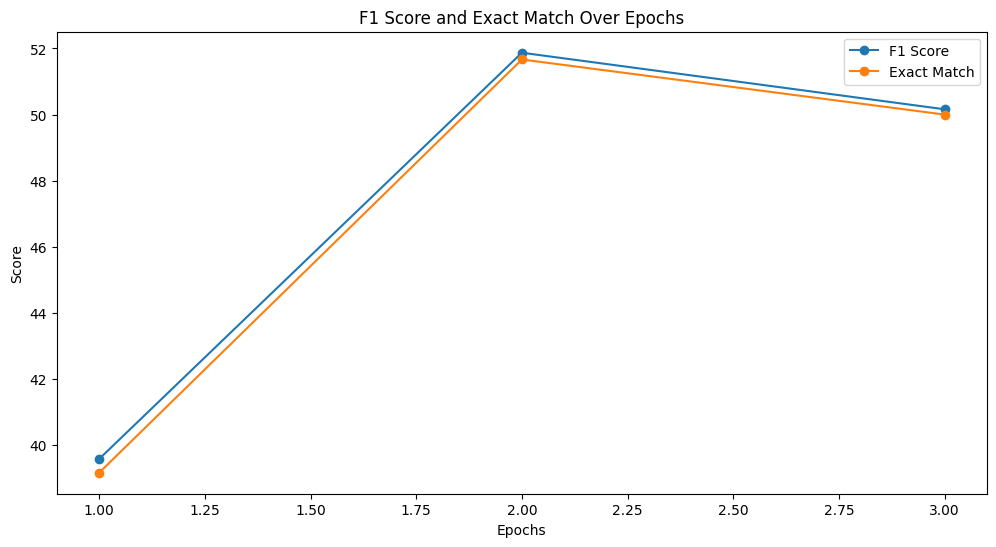

In [ ]:
# Visualize the F1 score and Exact Match over epochs
epochs = range(1, total_epochs + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_f1_scores, label='F1 Score', marker='o')
plt.plot(epochs, val_em_scores, label='Exact Match', marker='o')
plt.title('F1 Score and Exact Match Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

## **Visualize the training and validation losses over epochs**

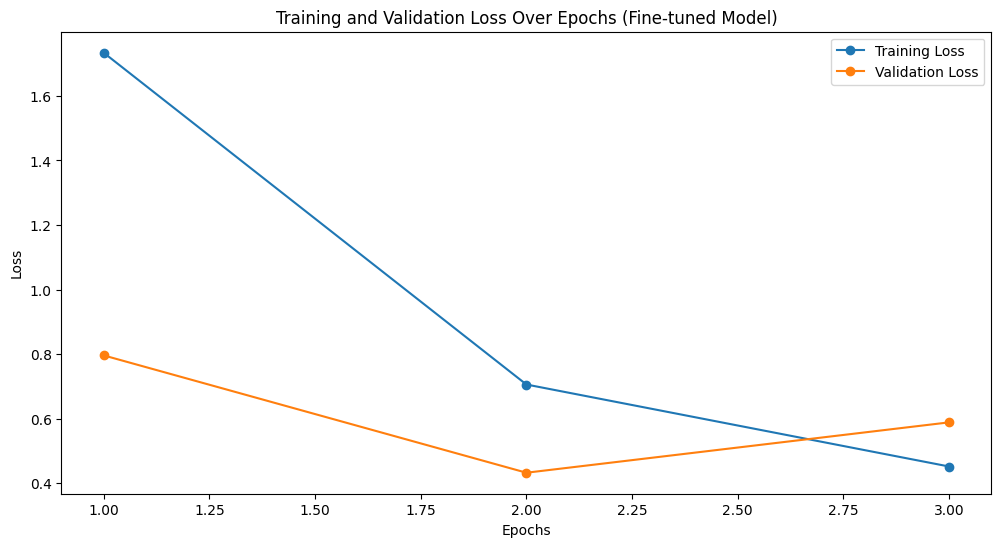

Training completed.


In [ ]:
# Visualize the training and validation losses over epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, valid_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs (Fine-tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("Training completed.")

## **Comparision between Base and Finetuned model**

In [ ]:
# Load the trained Model and evaluate the performance on the validation dataset
model_path = "/content/drive/MyDrive/bert_finetuned_squad.pt"
QA_model.load_state_dict(torch.load(model_path))
QA_model.to(compute_device)

# Comparision between base and finetuned model
print("Comparision between base and fine-tuned model")
val_predictions, val_loss = eval_performance(QA_model, valid_loader)
val_exact, val_f1 = evaluate_scores(valid_data, val_predictions)
print(f'Base Model - Exact Match: {base_model_exact}, F1: {base_model_f1}')
print(f"Fine-tuned Exact Match (EM): {val_exact:.2f}%")
print(f"Fine-Tuned F1 Score: {val_f1:.2f}%")

Comparision between base and fine-tuned model
Base Model - Exact Match: 23.333333333333332, F1: 23.747293644957843
Fine-tuned Exact Match (EM): 51.67%
Fine-Tuned F1 Score: 51.87%


## **User Interface**

In [ ]:
# Install the spellchecker package
!pip install pyspellchecker

# Imports
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import torch
from transformers import BertTokenizer, BertForQuestionAnswering
from spellchecker import SpellChecker
from google.colab import drive

# Access the drive for the saved model
drive.mount("/content/drive")

# Initialize and load the model
model_checkpoint_path = "/content/drive/MyDrive/bert_finetuned_squad.pt"
qa_model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Initialize the corresponding tokenizer
model_identifier = "bert-base-uncased"
tokenizer_bert = BertTokenizer.from_pretrained(model_identifier)
# Load the trained model
qa_model.load_state_dict(torch.load(model_checkpoint_path, map_location=torch.device('cpu')))

# Model in eval mode
qa_model.eval()

# Initialize spell checker
spell_check = SpellChecker()

# Spell correction in the provided text
def correct_spelling(text):
    correct_spell_text = []
    each_word = text.split()
    misspelled = spell_check.unknown(each_word)
    for word in each_word:
        corrected_word = spell_check.correction(word) if word in misspelled else word
        correct_spell_text.append(corrected_word if corrected_word is not None else "")
    return ' '.join(correct_spell_text)


# Title display for the UI
title = widgets.HTML(
    value="<h2 style='text-align:center; color:#007bff; margin-bottom:10px; font-size: 28px;'>Question Answering System</h2>"
)

# UI Elements
# Context label and textarea
context_label = widgets.Label('Context:', layout=widgets.Layout(width='5%', font_weight='bold', font_size='20px'))
context_input = widgets.Textarea(placeholder='Type context here...', layout=widgets.Layout(width='95%', height='250px'))
context_box = widgets.HBox([context_label, context_input], layout=widgets.Layout(justify_content='space-between', width='95%'))

# Question label and Question input
question_label = widgets.Label('Question:', layout=widgets.Layout(width='5%', font_weight='bold', font_size='20px'))
question_input = widgets.Text(placeholder='Type your question here...', layout=widgets.Layout(width='95%'))
question_box = widgets.HBox([question_label, question_input], layout=widgets.Layout(justify_content='space-between', width='95%'))

# Get Answer button to get the answer
Get_answer_button = widgets.Button(description="Get Answer", button_style='success', layout=widgets.Layout(width='140px', height='45px', margin='12px 0 0 0', font_size='18px'))
output = widgets.Output(layout=widgets.Layout(border='1px solid black', margin='10px 0 0 0', height='auto', overflow='auto'))

# Ethical consideration statement and checkbox
ethical_statement = "By using this question answering system, you acknowledge that the responses generated may contain biases. Ensure to verify information and use responsibly."
ethical_label = widgets.Label(ethical_statement, layout=widgets.Layout(width='auto', font_size='20px'))
checkbox = widgets.Checkbox(value=False, layout=widgets.Layout(width='auto'))
checkbox_group = widgets.HBox([checkbox, ethical_label], layout=widgets.Layout(align_items='center', width='100%', justify_content='flex-start'))

# Main body container
main_container = widgets.VBox([title, checkbox_group, context_box, question_box, Get_answer_button, output],
                              layout=widgets.Layout(border='2px solid #007bff', align_items='center',
                                                    width='95%', margin='10px auto', padding='10px'))

# Button Click Event Handler
def on_button_clicked(b):
    with output:
        clear_output()
        if checkbox.value:
            text_context = context_input.value
            query_text = correct_spelling(question_input.value if question_input.value else " ")
            encoded_input = tokenizer_bert.encode_plus(query_text, text_context, add_special_tokens=True, return_tensors="pt")
            question_id = encoded_input["input_ids"].tolist()[0]
            model_output = qa_model(**encoded_input)
            span_start = torch.argmax(model_output.start_logits)
            span_end = torch.argmax(model_output.end_logits) + 1
            predicted_answer = tokenizer_bert.decode(question_id[span_start:span_end], skip_special_tokens=True)
            if predicted_answer=="":
              predicted_answer ="No Answer available"
            display(HTML(f"<div style='font-size: 18px; margin: 12px; padding: 12px; border-radius: 5px; background-color: #f0f8ff;'>\
                          <strong>Answer:</strong> {predicted_answer}</div>"))
        else:
            print("Please agree to the ethical considerations before proceeding.")

# Attach the event handler to the button
Get_answer_button.on_click(on_button_clicked)

# Display UI with the main container
display(main_container)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.1 MB/s eta 0:00:00
Mounted at /content/drive


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]